# Angular Resolution
In this notebook we find the resolution as a function of polar angle from the beam's axis for the LHCb using the simulated data tuple.

In [147]:
import pandas as pd
import numpy as np
import uproot as up
import matplotlib.pyplot as plt
import mplhep as hep

np.random.seed(0)
# Set random seed for reproducibility

In [148]:
sname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/fullSampleOct2021/job207-CombDVntuple-15314000-MC2016MD_Full-pKmue-MC.root"
lepton = 'L2'

fts = ['Lb_BKGCAT', f'{lepton}_TRUEP_Z', f'{lepton}_PZ', f'{lepton}_TRUEPT', f'{lepton}_PT']

with up.open(sname + ":DTT1520me/DecayTree") as f:
    df = f.arrays(["eventNumber"] + fts, library='pd')
    df.set_index("eventNumber", inplace=True)
    df = df.sample(frac=1, random_state=0)
    df = df[~df.index.duplicated(keep='first')]

df.head()

,Lb_BKGCAT,L2_TRUEP_Z,L2_PZ,L2_TRUEPT,L2_PT
eventNumber,,,,,
877549,60,0.00,3532.95,0.000000,366.698521
933189,10,63993.29,62326.92,2908.797690,2835.416799
256342,10,11486.23,11479.84,1741.631572,1738.997389
1271785,10,10346.22,10414.29,1558.069005,1570.025682
127625,60,49540.65,46290.01,3171.354296,2964.309828


## Make Angular Features

In [149]:
# First remove non-signal candidate events
df = df[df['Lb_BKGCAT'].isin([10, 50])]
df.head()

,Lb_BKGCAT,L2_TRUEP_Z,L2_PZ,L2_TRUEPT,L2_PT
eventNumber,,,,,
933189,10,63993.29,62326.92,2908.797690,2835.416799
256342,10,11486.23,11479.84,1741.631572,1738.997389
1271785,10,10346.22,10414.29,1558.069005,1570.025682
937680,10,34643.19,32110.44,1562.462777,1452.249537
1059409,10,10215.15,8053.08,1460.982464,1149.379028


In [150]:
df[lepton + "_P"] = np.sqrt(df[lepton + "_PZ"]**2 + df[lepton + "_PT"]**2)
df[lepton + "_TRUEP"] = np.sqrt(df[lepton + "_TRUEP_Z"]**2 + df[lepton + "_TRUEPT"]**2)
df[lepton + "_Theta"] = np.arcsin(df[lepton + '_PT']/df[lepton + '_P'])
df[lepton + "_TRUE_Theta"] = np.arcsin(df[lepton + '_TRUEPT']/df[lepton + '_TRUEP'])
df[lepton + "_D_Theta"] = np.arcsin(df[lepton + "_Theta"] - df[lepton + "_TRUE_Theta"])

df.head()

,Lb_BKGCAT,L2_TRUEP_Z,L2_PZ,L2_TRUEPT,L2_PT,L2_P,L2_TRUEP,L2_Theta,L2_TRUE_Theta,L2_D_Theta
eventNumber,,,,,,,,,,
933189,10,63993.29,62326.92,2908.797690,2835.416799,62391.381978,64059.365194,0.045461,0.045423,0.000038
256342,10,11486.23,11479.84,1741.631572,1738.997389,11610.806964,11617.519535,0.150340,0.150482,-0.000142
1271785,10,10346.22,10414.29,1558.069005,1570.025682,10531.971176,10462.879494,0.149630,0.149470,0.000160
937680,10,34643.19,32110.44,1562.462777,1452.249537,32143.263458,34678.406874,0.045196,0.045071,0.000125
1059409,10,10215.15,8053.08,1460.982464,1149.379028,8134.689277,10319.096825,0.141768,0.142058,-0.000290


## Group Data into Bins
We want to find the angular resolution as a function of angle. Hence we should group these data first into bins by L1_TRUE_Theta i.e. the angle with respect to the beam axis and then find the angular resolution at each angle!

In [153]:
bins = 100
bin_edges = np.linspace(np.min(df[f'{lepton}_TRUE_Theta']), np.max(df[f'{lepton}_TRUE_Theta']), bins+1)
bin_width = bin_edges[1] - bin_edges[0]
bin_centres = np.array([np.mean(bin_edges[i:i+2]) for i in range(len(bin_edges) - 1)])

quartiles = np.linspace(0., 1., bins+1)

df['TRUE_Theta_Bin'] = pd.qcut(df[f'{lepton}_TRUE_Theta'], q=quartiles, labels=np.arange(1, bins+1))
df.dropna(axis=0, inplace=True)
df.head()

,Lb_BKGCAT,L2_TRUEP_Z,L2_PZ,L2_TRUEPT,L2_PT,L2_P,L2_TRUEP,L2_Theta,L2_TRUE_Theta,L2_D_Theta,TRUE_Theta_Bin
eventNumber,,,,,,,,,,,
933189,10,63993.29,62326.92,2908.797690,2835.416799,62391.381978,64059.365194,0.045461,0.045423,0.000038,14
256342,10,11486.23,11479.84,1741.631572,1738.997389,11610.806964,11617.519535,0.150340,0.150482,-0.000142,78
1271785,10,10346.22,10414.29,1558.069005,1570.025682,10531.971176,10462.879494,0.149630,0.149470,0.000160,78
937680,10,34643.19,32110.44,1562.462777,1452.249537,32143.263458,34678.406874,0.045196,0.045071,0.000125,14
1059409,10,10215.15,8053.08,1460.982464,1149.379028,8134.689277,10319.096825,0.141768,0.142058,-0.000290,75


## Calculating Resolution in each Bin

In [154]:
g = df.groupby('TRUE_Theta_Bin')
# Group the data by angular bin

## Visualise Results
Now to check what the resolution in each bin looks like we plot our results. The best way to do this is to use mplhep so our plots look like ROOT plots. We will plot the results for a random selection of groups (angular bins).

In [155]:
plt.style.use([hep.style.ROOT, hep.style.firamath])
# Set the plot style

internal_bins = 40
# Set the number of bins to use within in master bin

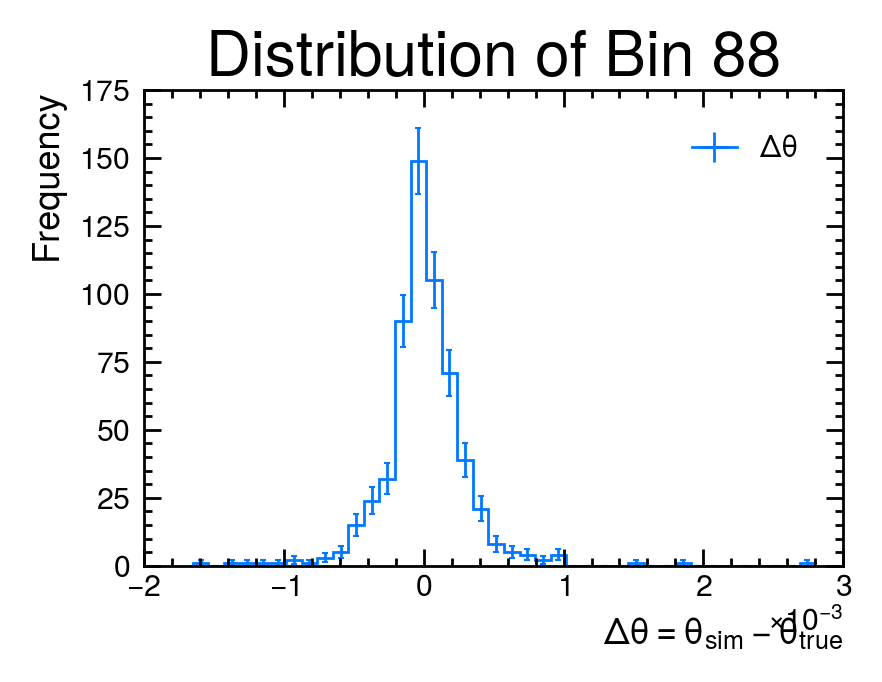

In [158]:
# Pick a random group
data = g.get_group(np.random.choice(df['TRUE_Theta_Bin'].to_numpy(), 1)[0])
h, bins = np.histogram(data[f'{lepton}_D_Theta'], bins=internal_bins)

# Make the plot
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.set_title(f"Distribution of Bin {data['TRUE_Theta_Bin'].unique()[0]}")
hep.histplot(h, bins, yerr=np.sqrt(h), ax=ax, label=r'$\Delta\theta$')
ax.set_xlabel(r'$\Delta\theta=\theta_{sim}-\theta_{true}$')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()

## Fitting Gaussians
Now to find the errors within each bin we want to fit a Gaussian to the distribution within each group and extract the fit parameters as the standard deviation within these is the resolutions error and the mean is the actual resolution at some given group.

In [159]:
from scipy.optimize import curve_fit

# Define the Gaussian we will fit to each bin, include an amplitude term as the bins are not normalised
def gauss(x, A, mu, sigma):
    return (A/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x-mu)/sigma)**2)

In [161]:
params = []
for i, group in enumerate(g):
    h, bins = np.histogram(group[1][f'{lepton}_D_Theta'], bins=internal_bins)
    bin_centres = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]
    try:
        popt, pcov = curve_fit(gauss, bin_centres, h)
        params.append((popt, pcov))
    except RuntimeError:
        print(f'Failed on group {i}')
        params.append(([0, 0, 0], [0, 0, 0]))
    

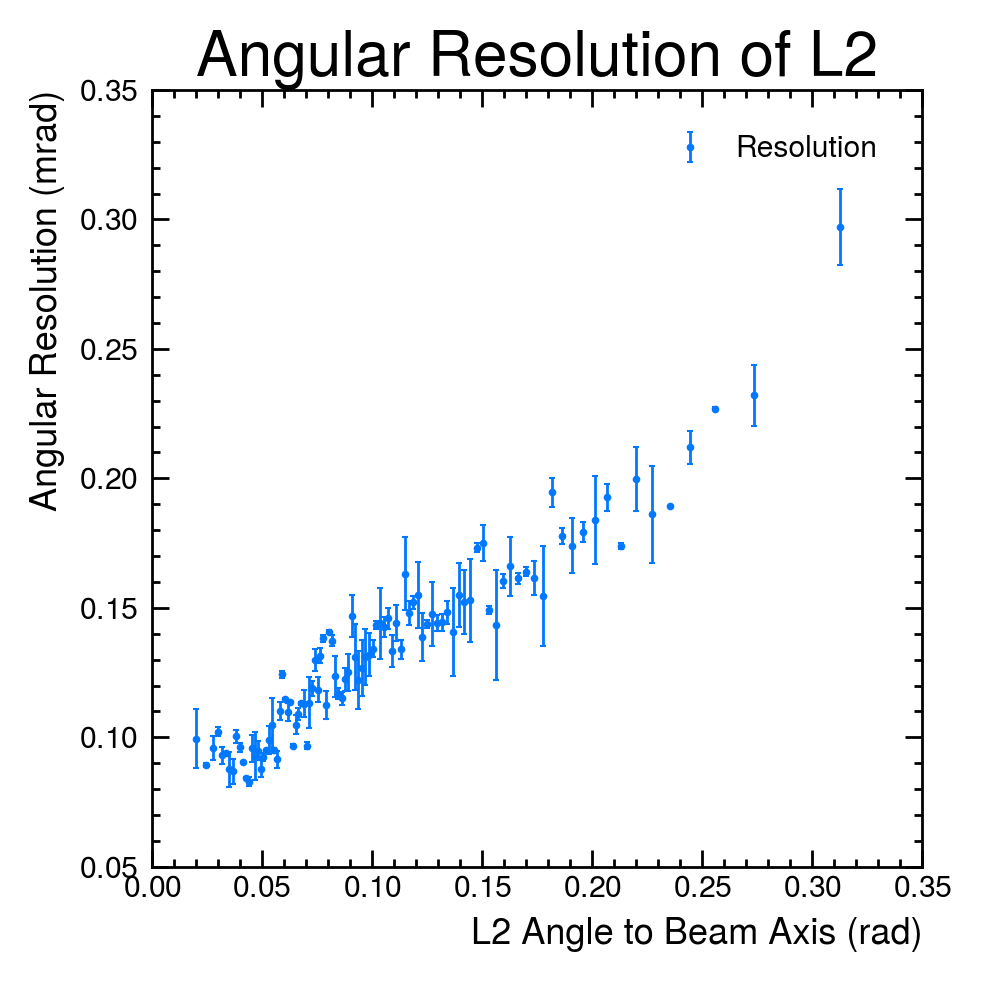

In [163]:
x = np.array([np.mean(grp[1][f'{lepton}_TRUE_Theta']) for grp in g])
y = np.abs(np.array([p[0][2] for p in params])*1e3)
yerr = np.array([p[0][1] for p in params])*1e3

all = np.array([x, y, yerr]).T
all = all[np.where(all[:,1] != 0)]

fig, ax = plt.subplots(1, 1)
ax.set_title(f"Angular Resolution of {lepton}")
ax.errorbar(all[:,0], all[:,1], yerr=all[:,2], fmt='.', label='Resolution')
ax.set_ylabel('Angular Resolution (mrad)')
ax.set_xlabel(f'{lepton} Angle to Beam Axis (rad)')
ax.legend()
plt.tight_layout()
plt.savefig(f'../images/Resolution/{lepton}_Angular_Resolution.png', dpi=800)
plt.show()